### Edgar Moises Hernandez-Gonzalez
#### 28-03-20-27-08-20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 135x31

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2
from scipy.signal import spectrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
#from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv",
                       header=None).iloc[:, 0:768]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv",
                       header=None).iloc[:, 1536:2304]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv",
                      header=None).iloc[:, 0:768]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv",
                      header=None).iloc[:, 1536:2304]

In [6]:
x_train = pd.concat([c3_train, c4_train], axis=1)
x_test = pd.concat([c3_test, c4_test], axis=1)

In [7]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_train.csv",
                      header=None).values
y_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_test.csv",
                     header=None).values

In [8]:
#class_names = ['left hand', 'right hand', 'both feet', 'tongue']
class_names = ['izquierda', 'derecha']

In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 1536)
(140, 1536)
(140, 1)
(140, 1)


In [10]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 140
n_samples_test : 140


In [11]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [12]:
#unir 2 canales y 3 segundos
def unir_espectrogramas_vertical(data):
  fs = 128
  datos = np.zeros((data.shape[0],90,17))
  temporal = np.zeros((90,17))
  for i in range(data.shape[0]): #n muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*768:(j+1)*768]
      sig = sig[32:416]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=128, window='hann', nperseg=128,
                              noverlap=112, nfft=256, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
#llamar a unir_espectrogramas_vertical(data)
inicio = time.time()

x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
0
100
Tiempo: 0.8740136623382568


In [14]:
print(x_train.shape)
print(x_test.shape)

(140, 90, 17)
(140, 90, 17)


In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.008304093936571649
0.009925350444004888
2.2028109391356174e-11
6.89847106360668e-12
8.927016153753592e-05
0.00010200371546207688


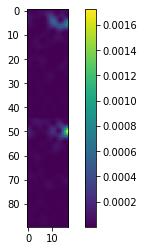

In [16]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

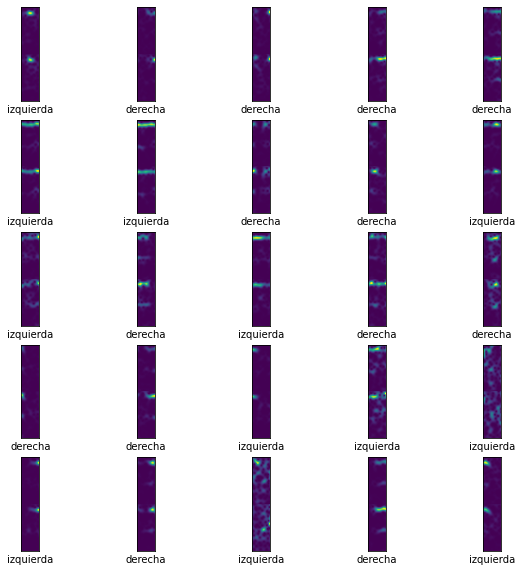

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i,0]])
plt.show()

In [18]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(140, 1, 90, 17, 1)
(140, 1, 90, 17, 1)


In [19]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, activation='tanh', dropout=0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.4185616672039032
accuracy:  0.8214285969734192
confusion matrix:
 [[61  9]
 [16 54]]


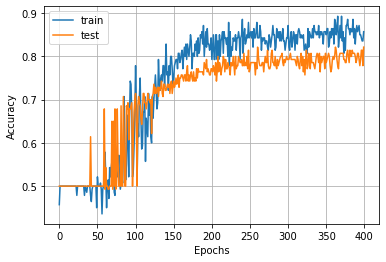

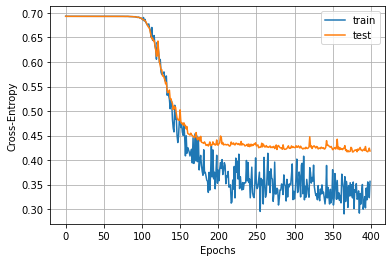


Resultados:
loss: [0.4185616672039032]
accuracy: [0.8214285969734192]
Tiempo: 36.720012187957764


In [21]:
inicio = time.time()
array_loss = []
array_acc = []
for i in range(1):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=400, batch_size=16,
                      validation_data=(x_test, y_test), verbose=0)
                      #callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 1, 90, 17, 64)     640       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 45, 8, 64)      0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 45, 8, 64)      36928     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 22, 4, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 5632)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                725120    
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [25]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.8214
std: (+/- 0.0000)
Max Accuracy: 0.8214
Tiempo: 36


In [26]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i,0], img[i]
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img.reshape(90,17))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [27]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i,0]
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [29]:
num_test = 28
print("Etiqueta verdadera", y_test[num_test])
prediccion = model.predict(x_test[num_test].reshape(1,1,90,17,1))
print("Etiqueta predicha", prediccion.argmax())

Etiqueta verdadera [0]
Etiqueta predicha 0


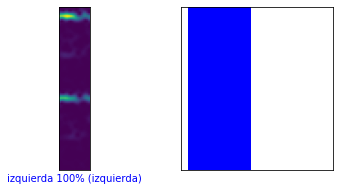

In [30]:
i = num_test
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, probabilidades, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, probabilidades,  y_test)
plt.show()

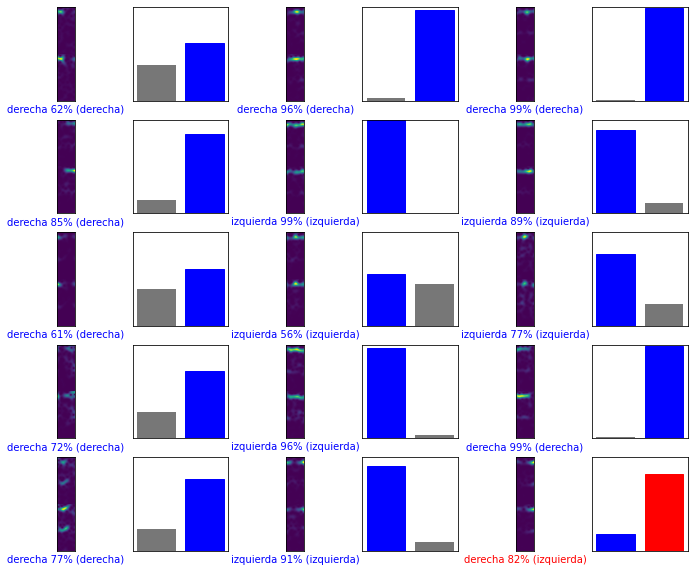

In [31]:
#Graficar imagenes, etiqueta predicha y etiqueta verdadera
#Correcta en azul, incorrecta en rojo
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probabilidades, y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, probabilidades, y_test)
plt.show()